# PotentioDynamic Scattering Microscopy (PDSM)

## Aanalyzing the oscillating contrast 
 
*Author: Sanli Faez (s.faez@uu.nl)*

* last update: 20/4/2019
    * using the LED flash to set time zero
    * using the recorded current and potential for creating the Intensity-Potential-Current curve
* 2nd version: 27/2/2019
* 1st version: 14/2/2019

The main use of this notebook is to **test on a small scale** the functions necessary for extracting the scattering contrast oscillations. The optimized parameters can be useful for analyzing big files using other routines.

The measurements are done using the a TIR scattering microscope at the surface of a transparent slide while an alternating potential is applied between the slide and a counter-electrode in the solution. The apparatus in Utrecht generates HDF5 files for videos and records the passing electric current, synced with the camera, using a NI-DAQ card. Some of the current measurements are also done on a Tektronics osciloscope, which provides a higher bandwidth, but datapoints are not synced with the camera.  

### General advice
Use the notebook for testing small datasets, or fractions of larger ones. Once the reliability is verfied, add the code pieces to an script and process larger batches of data.

### Roadmap
Each step is separately tested and verified.

* 1) Looking at current and applied potential to extract frame numbers at beginning of each cycle
* 2) Averaging the intensity-potential relation over all cycles
* 3) Summarizing the statistics of PD contrast over several interesting points
    * points of highest PD contrast
    * points of opposite phase

#### wishlist
* comparing responses for different conditions in one graph
* make movie from cleaned up data


In [1]:
%pylab inline

import sys
sys.path.append('/Users/sanli/Repositories/PDSM') #uncomment including extra files are needed

import matplotlib.pyplot as plt
import numpy as np
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
# choose filename for a measurement condition and output directory
fdir = r'/Users/sanli/Repositories/Data/PDSM_UnderInvestigation/2019-04-30-Pt/'
mfile = 'PtNaCl_10mM_r2.hdf5'
fext = '.hdf5'
fpath = fdir + mfile 
print(fpath)
outputdir = fdir + 'analyzed/' + mfile.strip(fext) + '/' 
if not os.path.exists(outputdir):
    os.makedirs(outputdir)

/Users/sanli/Repositories/Data/PDSM_UnderInvestigation/2019-04-30-Pt/PtNaCl_10mM_r2.hdf5


### Import the trigger sequence to reconstruct the applied potential and current
* for each measurement the trigger series is recorded and saved as numpy array

29220  times triggered
number of complete cycles: 145
[  69  269  469  668  868 1068 1268 1468 1668 1868] period=  199


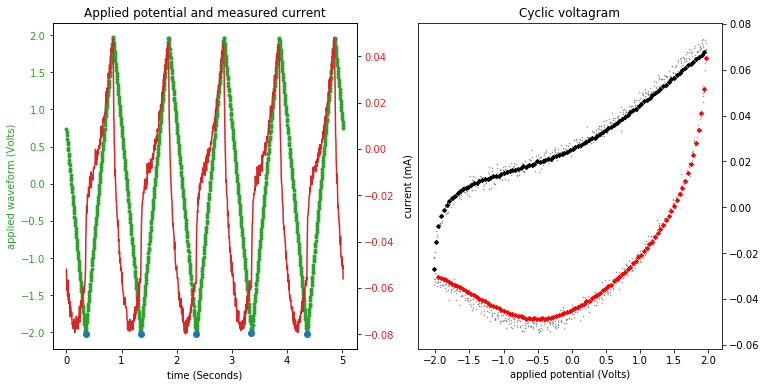

In [3]:
from PDSM_func import AvgWaveForm as awf

tracknumber = 8
real_period = 1 #The applied waveform period in Hz
halfper = 100

trigfile = mfile.strip(fext) + '_m' + str(tracknumber)+ '.npy'  # trigger file corresponding to each sequence 

trigdata = np.load(fdir+trigfile)
ntrig = np.size(trigdata,0)
print(ntrig, " times triggered")
R_series = 1.008 # serial resistor in kOhm, used for measuring current

scycles = awf.find_potential_cycles(trigdata[:,0], 2*halfper)
period = awf.find_nframes_cycle(scycles)
full_cycles = np.size(scycles) - 1
print('number of complete cycles:', full_cycles)
print(scycles[:10], 'period= ', period)
ns = 10 * halfper # choosing the few first cycles for viewing
# plotting the trigger data for overview
avg_potential = awf.avg_potential_cycle(trigdata[:scycles[full_cycles],0], scycles[:full_cycles])
vdrop = trigdata[:scycles[full_cycles],1] - np.mean(trigdata[:,1])
avg_current = awf.avg_potential_cycle(vdrop, scycles[:full_cycles]) / R_series  # current in mA
###Plotting the change of intensity over the sequence
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
color = 'tab:green'

taxis = np.arange(ns)/period * real_period
ax1.set_title("Applied potential and measured current")
ax1.set_xlabel('time (Seconds)')
ax1.set_ylabel('applied waveform (Volts)', color=color)  # we already handled the x-label with ax1
ax1.plot(taxis, trigdata[:ns,0], '.',color=color)
ax1.plot(taxis[scycles[:5]], trigdata[scycles[:5],0], 'o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.plot(taxis, trigdata[:ns,1]/R_series, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = plt.subplot(122)
ax3.set_title("Cyclic voltagram")
ax3.scatter(trigdata[:ns,0], vdrop[:ns] / R_series, color = 'grey', s=0.2)
ax3.scatter(avg_potential[:halfper], avg_current[:halfper], c = 'k', marker="D", s=8)
ax3.scatter(avg_potential[halfper:], avg_current[halfper:], c = 'r', marker="D", s=8)
ax3.set_xlabel('applied potential (Volts)')
ax3.set_ylabel('current (mA)')
ax3.yaxis.tick_right()

outf = outputdir  + trigfile.strip('.npy') + '_IV.png'
fig.savefig(outf)
outf = outputdir  + trigfile.strip('.npy') + '_IV.npy'
np.save(outf, [avg_potential, avg_current])

### Import recorded image sequence files
- First next two cells for are HDF5 snap and video (UUTrack). 
- hdf5 files contain several sequences corresponding, each with a different trigger series

In [4]:
# ## run Only for snaps
# from PDSM_func import functionsDFSM as dfsm  #functions written and maintained by Kevin 
# data = dfsm.ImportHDF5data(fpath)
# data.setkey(0)
# print("Wherein there is :", data.getkeys())
# dset = data[0]['image'] # to read a single snap image
# print(dset.shape)
# fig = plt.figure(figsize=(16,10))
# plt.imshow(np.transpose(np.log10(dset)), vmin = 0.1, vmax=3)
# plt.show()
# previewfile = outputdir + 'single_snap'
# fig.savefig(previewfile)

In [5]:
# Import HDF5 video sequence:
from PDSM_func import functionsDFSM as dfsm  #functions written and maintained by Kevin 
data = dfsm.ImportHDF5data(fpath)
data.setkey(0)
print("Wherein there is :", data.getkeys())
data.resetkeys()

seq = data[tracknumber,1] #Sanli: what is the second index?
firstline = np.mean(seq[:,20,:], axis=0)
nf = np.size(firstline[firstline >0])
frames = seq[:,:,:nf]
Lx, Ly, nf = frames.shape
print(f"{nf} frames of size {Lx, Ly} in the sequence")

Data in /Users/sanli/Repositories/Data/PDSM_UnderInvestigation/2019-04-30-Pt/PtNaCl_10mM_r2.hdf5 :  ['2019-04-30 17:12:13.372000', '2019-04-30 17:16:20.534000', '2019-04-30 17:17:39.745000', '2019-04-30 17:20:04.222000', '2019-04-30 17:22:08.942000', '2019-04-30 17:24:58.656000', '2019-04-30 17:28:25.783000', '2019-04-30 17:31:04.832000', '2019-04-30 17:33:52.593000', '2019-04-30 17:36:46.348000', '2019-04-30 17:38:37.971000']
Wherein there is :  ['metadata', 'timelapse']
Wherein there is : ['metadata', 'timelapse']
29229 frames of size (522, 64) in the sequence


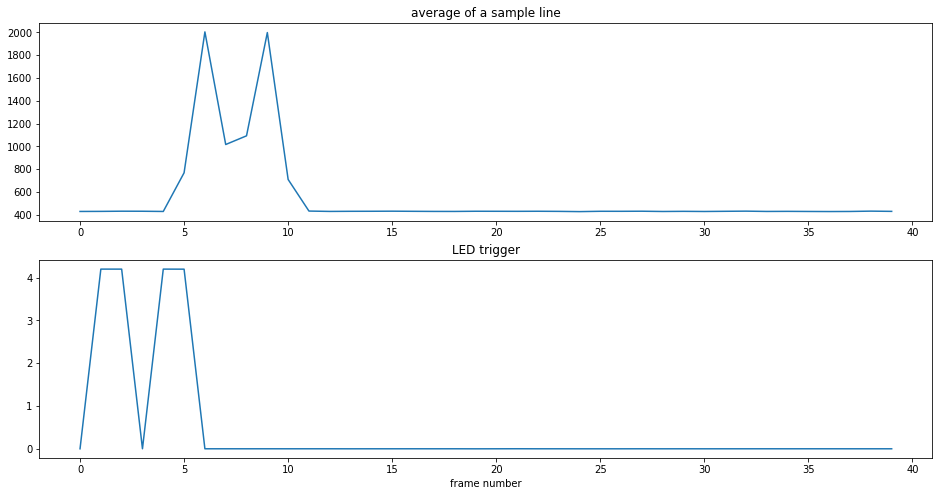

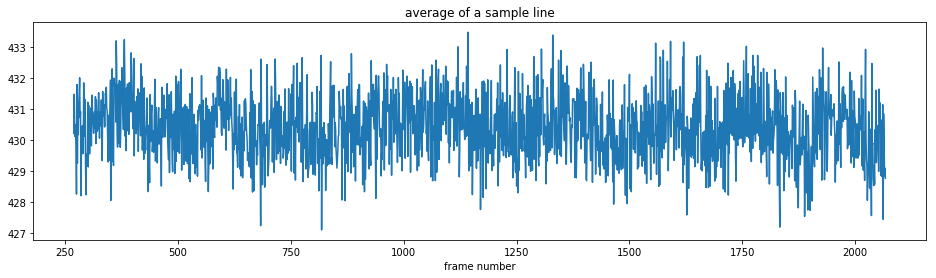

In [6]:
# if not os.path.exists(outputdir):
#     os.makedirs(outputdir)
cyc1, cyc2, cyc11 = scycles[0], scycles[1], scycles[10]
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot(211)
ax1.plot(firstline[:40])
ax1.set_title("average of a sample line")

ax2 = plt.subplot(212)
ax2.plot(trigdata[:40,2])
ax2.set_title("LED trigger")
ax2.set_xlabel("frame number")
plt.show()

fig2 = plt.figure(figsize=(16,4))
plt.plot(range(cyc2,cyc11),firstline[cyc2:cyc11])
plt.title("average of a sample line")
plt.xlabel("frame number")
plt.show()

previewfile = outputdir + 'singleline_seq' + str(tracknumber) + '.png'
fig2.savefig(previewfile)

### Correct for the delay between images and the recorded triggers
This problem has to be solved, for now, we can use the difference between sequence length to guess how many frames are missing in the trigger data.

After solving for this delay use the cycle starting indices to correct for the drift and then average over all cycles.

In [7]:
scycles = awf.find_potential_cycles(trigdata[:,0], 2*halfper)
scycles = scycles + 5
cyc1, cyc2, cyc11 = scycles[0], scycles[1], scycles[21]
print (cyc1, cyc2, cyc11)
print(scycles[:10])

74 274 4272
[  74  274  474  673  873 1073 1273 1473 1673 1873]


### Look at the mean intensity and variance over the first 10 cycles
Rule of thumb: {answer to how a good measurement looks like over all}

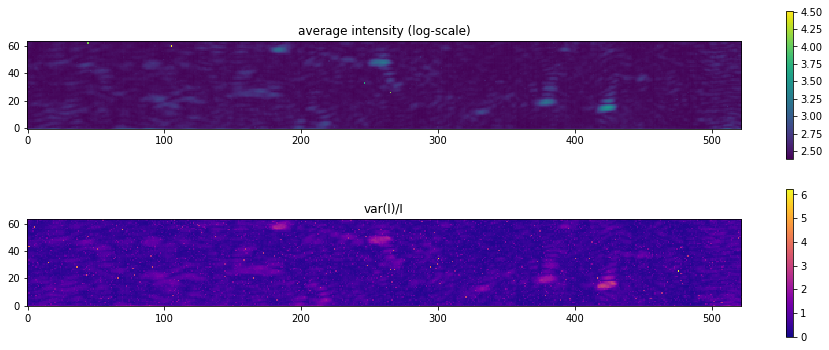

In [8]:
fig = plt.figure(figsize=(16,6))
ax1 = plt.subplot(211)
darkcounts = 100
mean_img = np.mean(frames[:,:,cyc1:cyc11],axis=2) - darkcounts
im = ax1.imshow(np.transpose(np.log10(mean_img)), origin ='lower')
plt.colorbar(im, ax = ax1)
plt.title("average intensity (log-scale)")

ax2 = plt.subplot(212)
var_img = np.var(frames[:,:,cyc1:cyc11],axis=2)
im = ax2.imshow(np.transpose(var_img/mean_img), cmap='plasma', origin ='lower')
plt.colorbar(im, ax = ax2)
plt.title('var(I)/I')

plt.show()
previewfile = outputdir + mfile.strip(fext)+'_var'
fig.savefig(previewfile)

### Plot intensity vs time at interesting spots

max variations at (265, 26) equal to 0.004009016329614351


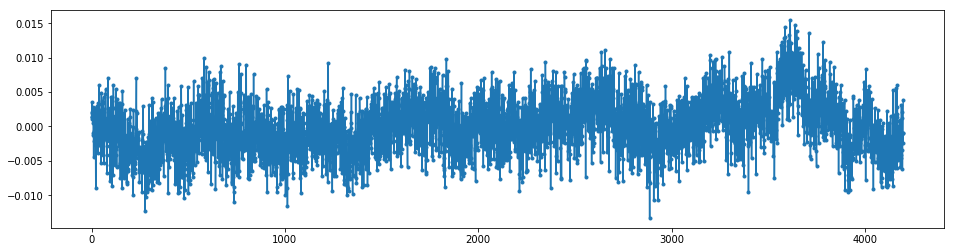

In [9]:
wx, wy = 10, 5  #estimated half width of speckle size, check that phase is constant over this area
selminmarg = var_img[wx:Lx-wx-1, wy:Ly-wy-1] #used to make sure chosen spekle spots are completely inside the selection

mx, my = np.unravel_index(np.argmax(selminmarg), selminmarg.shape)
mx = mx + wx
my = my + wy
specklemax = np.mean(np.mean(frames[mx-wx:mx+wx+1, my-wy:my+wy+1, cyc1:cyc11] - darkcounts, axis=0), axis=0)
tmpvar = np.mean(specklemax)
relvarsmax = (specklemax - tmpvar)/tmpvar
varspotmax = np.std(specklemax)/tmpvar
print(f'max variations at {(mx, my)} equal to {varspotmax}')

fig = plt.figure(figsize=(16,4))
plt.plot(relvarsmax, '.-')

plt.show()

### Find the Fourier component(s) corresponding to the oscillating potential

This part can be tricky if the oscillations are not prominent. Here we do it on the first 10 cycles, so the spectrum peaks at the same position; good to check it does.

Also check for presence of higher harmonics.

Fourier components: 4


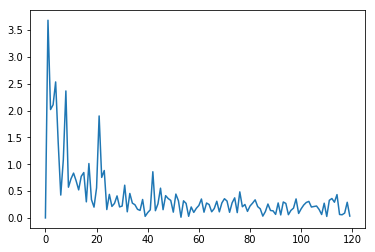

In [10]:
fspec = np.fft.rfft(relvarsmax)
maxfc = 120 #fourier index above which is irrelevant for the analysis
dcbase = 4   #fourier index below which counts as drift
plt.plot(abs(fspec[:maxfc]))
mfreq = dcbase + np.argmax(abs(fspec[dcbase:maxfc]))
print("Fourier components:", mfreq)
plt.show()

### Find the harmonic oscillation amplitude and phase

In [11]:
f= np.mean(scycles[1:]-scycles[:np.size(scycles)-1])
print ('average period = ',f)
cosw = - np.cos(2*np.pi*np.arange(1.0*(cyc11-cyc1))/f)
sinw = np.sin(2*np.pi*np.arange(1.0*(cyc11-cyc1))/f)
print('sum of weights:', np.sum(cosw), np.sum(sinw))
frames_cos = np.average(frames[:, :, cyc1:cyc11], axis = 2, weights = cosw)/(cyc11-cyc1)
frames_sin = np.average(frames[:, :, cyc1:cyc11], axis = 2, weights = sinw)/(cyc11-cyc1)
first_harmonic = np.power(frames_cos, 2) + np.power(frames_sin, 2)
phase = np.arctan(frames_sin/frames_cos)/np.pi

average period =  199.917241379
sum of weights: 0.262027470018 0.00519740404398


### Plot harmonic map and find interesting spots 
the spots with highest harmonic value are interesting. To worth looking at, they should be separated enough.

[[  2.65000000e+02   2.60000000e+01   1.37504395e+04   1.26692934e+01
   -1.41424963e+03   2.00026253e+06]
 [  2.46000000e+02   3.30000000e+01   5.15166603e+03   5.09065649e+00
    1.21532152e+02   1.47959788e+04]
 [  4.24000000e+02   1.50000000e+01   3.25526846e+03  -3.56588357e+01
    1.52934983e+03   2.34018246e+06]
 [  2.60000000e+02   4.80000000e+01   1.65838113e+03  -2.98112250e+01
    3.00404392e+02   9.11315080e+04]
 [  3.79000000e+02   1.90000000e+01   1.56470319e+03   9.05500980e+00
    3.87134130e+02   1.49954828e+05]
 [  2.14000000e+02   1.30000000e+01   4.04110529e+02   1.38746555e+01
   -7.06603850e+02   4.99481507e+05]
 [  2.35000000e+02   4.90000000e+01   4.64559314e+02   1.60670050e+01
   -5.78616769e+02   3.35055514e+05]
 [  1.92000000e+02   1.60000000e+01   3.57598380e+02   1.34347220e+01
   -5.05322451e+02   2.55531272e+05]
 [  3.33000000e+02   1.30000000e+01   6.02404478e+02   2.18845861e+01
   -6.17244120e+02   3.81469239e+05]
 [  4.37000000e+02   3.70000000e+01  

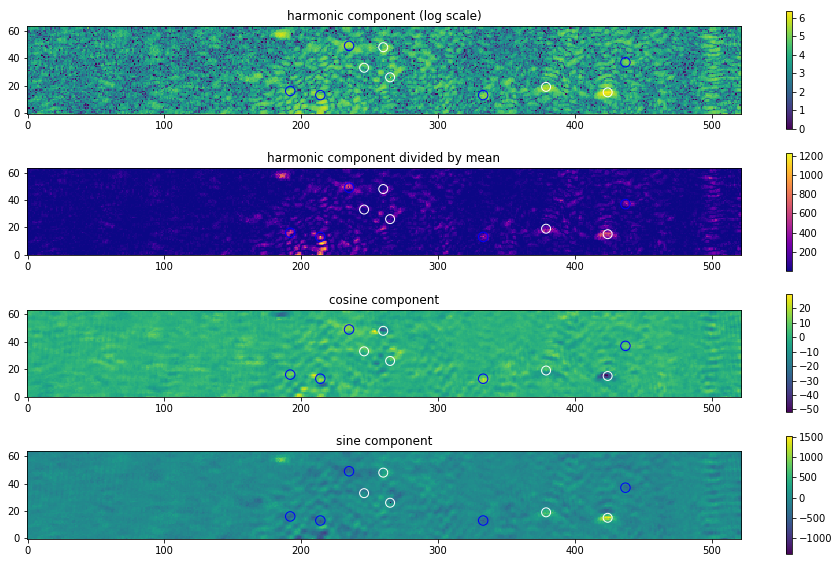

In [12]:
nspots = 10

fig = plt.figure(figsize=(16,10))
ax1 = plt.subplot(411)
im = ax1.imshow(np.transpose(np.log10(first_harmonic)), vmin = 0,origin ='lower')
plt.colorbar(im, ax = ax1)
ax1.set_title("harmonic component (log scale)")

ax2 = plt.subplot(412)
im = ax2.imshow(np.transpose((first_harmonic/mean_img)), vmin = 1, cmap='plasma', origin ='lower')
plt.colorbar(im, ax = ax2)
ax2.set_title('harmonic component divided by mean')

ax3 = plt.subplot(413)
im = ax3.imshow(np.transpose(frames_cos), origin ='lower')
plt.colorbar(im, ax = ax3)
ax3.set_title('cosine component')

ax4 = plt.subplot(414)
im = ax4.imshow(np.transpose(frames_sin), origin ='lower')
plt.colorbar(im, ax = ax4)
ax4.set_title('sine component')

spotmap = np.copy(mean_img)
spotmap_alt = np.copy(first_harmonic/mean_img)  #an alternative way of chosing interesting spots
# spotmap[:250,:] = 0 * spotmap[:250,:]
# spotmap_alt[:250,:] = 0 * spotmap[:250,:]

spots = []
wx, wy = 18, 10  #minimum separation between interesting spots
selminmarg = spotmap[wx:Lx-wx-1, wy:Ly-wy-1] #used to make sure chosen speckle spots are completely inside
selminmarg_alt = spotmap_alt[wx:Lx-wx-1, wy:Ly-wy-1] #used to make sure chosen speckle spots are completely inside

nbright = 5

for i in range(nspots):
    if i<nbright:
        mx, my = np.unravel_index(np.argmax(selminmarg), selminmarg.shape)
    else:
        mx, my = np.unravel_index(np.argmax(selminmarg_alt), selminmarg.shape)
        
    mx = mx + wx
    my = my + wy
    spots = numpy.concatenate([spots, [mx, my, mean_img[mx, my], frames_cos[mx, my], frames_sin[mx, my], first_harmonic[mx, my]]], axis=0)
    spotmap[mx-wx:mx+wx, my-wy:my+wy] = 0 * spotmap[mx-wx:mx+wx, my-wy:my+wy]
    spotmap_alt[mx-wx:mx+wx, my-wy:my+wy] = 0 * spotmap_alt[mx-wx:mx+wx, my-wy:my+wy]

    
    
spots = spots.reshape(nspots,6)
print(spots)

#mark spot positions
ax1.scatter(spots[:nbright,0], spots[:nbright,1], s=80, facecolors='none', edgecolors='w')
ax2.scatter(spots[:nbright,0], spots[:nbright,1], s=80, facecolors='none', edgecolors='w')
ax3.scatter(spots[:nbright,0], spots[:nbright,1], s=80, facecolors='none', edgecolors='w')
ax4.scatter(spots[:nbright,0], spots[:nbright,1], s=80, facecolors='none', edgecolors='w')

#mark spot positions
ax1.scatter(spots[nbright:,0], spots[nbright:,1], s=90, facecolors='none', edgecolors='b')
ax2.scatter(spots[nbright:,0], spots[nbright:,1], s=90, facecolors='none', edgecolors='b')
ax3.scatter(spots[nbright:,0], spots[nbright:,1], s=90, facecolors='none', edgecolors='b')
ax4.scatter(spots[nbright:,0], spots[nbright:,1], s=90, facecolors='none', edgecolors='b')

plt.show()
previewfile = outputdir + mfile.strip(fext)+ '_seq' + str(tracknumber) + '_harmonic.png'
fig.savefig(previewfile)

output = outputdir + mfile.strip(fext)+ '_seq' + str(tracknumber) +'_spotxy.npy'
np.save(output, spots)

### Plot intensity vs cell potential for interesting spots

In [13]:
print(period)
print (np.size(avg_potential))

199
199


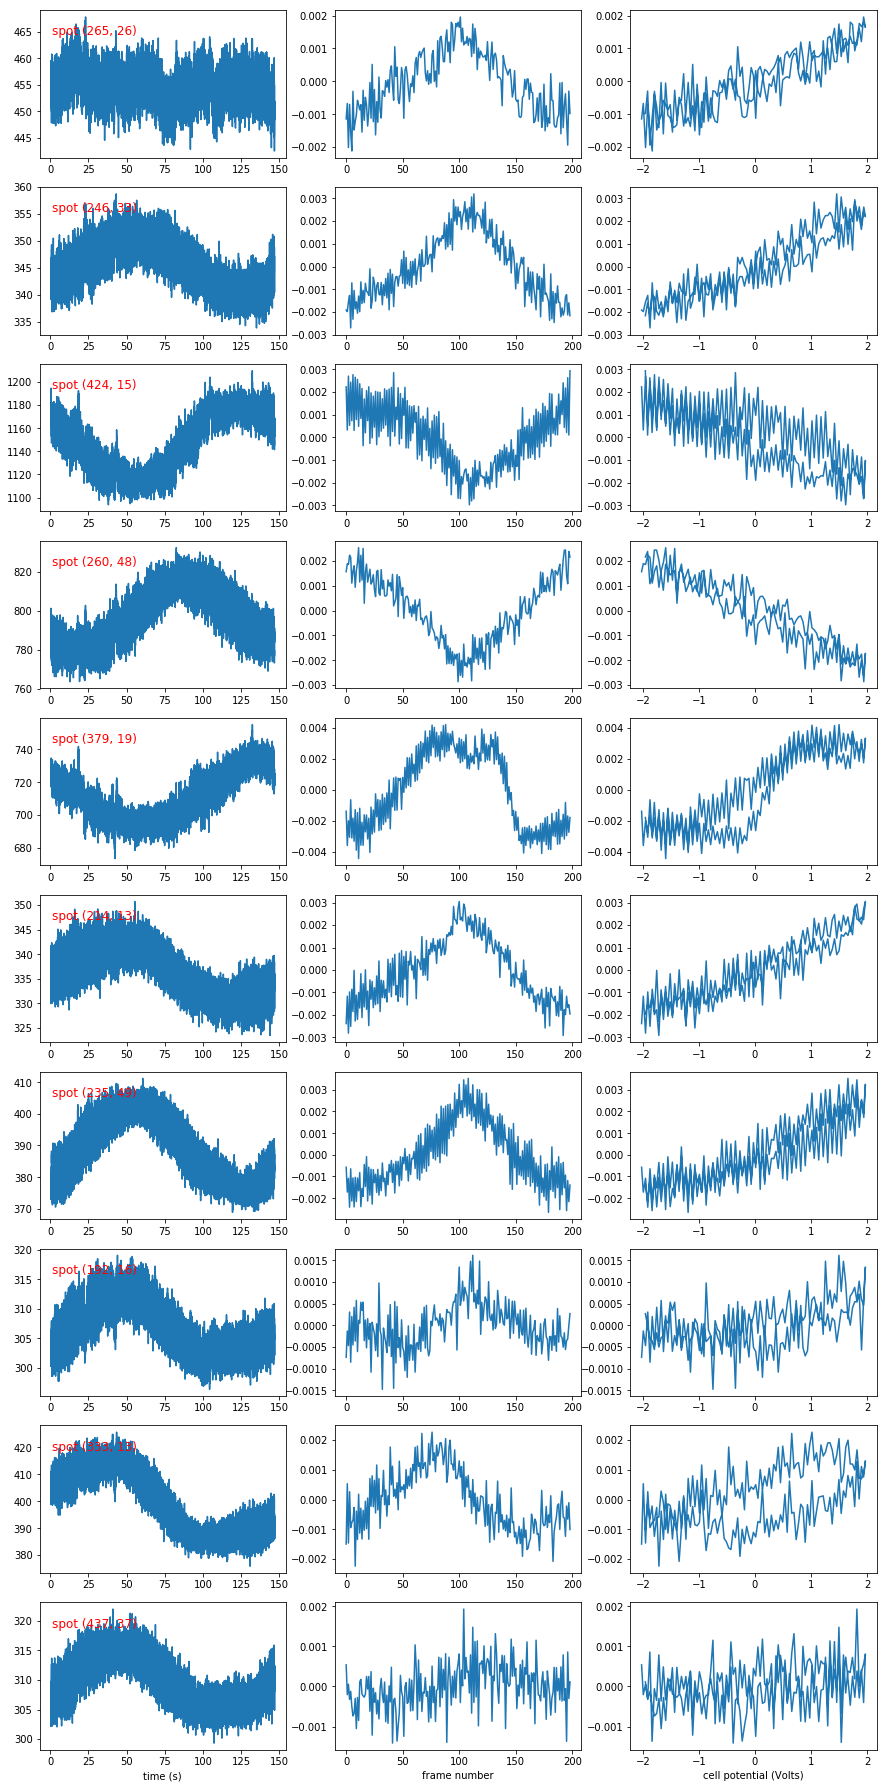

(11, 199)


In [14]:
wx, wy = 6, 3  #size of speckle spot considered as one point

nspots = 10
row, col = nspots, 3
fig = plt.figure(figsize=(15,32))
taxis = real_period * np.arange(cyc1,nf)/period
voltagram = [np.copy(avg_potential)]
for i in range(nspots):
    mx, my = int(spots[i,0]), int(spots[i,1])
    spot = np.mean(np.mean(frames[mx-wx:mx+wx+1, my-wy:my+wy+1, :] - darkcounts, axis=0), axis=0)
    ax1 = plt.subplot(row, col, 3*i+1)
    ax1.plot(taxis, spot[cyc1:])
    ax1.text(0.05,0.9, f"spot {(mx, my)}", transform=ax1.transAxes, fontsize=12, color = 'red', va='top')
    avg_di = awf.avg_intensity_cycle(spot, scycles)/np.mean(spot[cyc1:])
    voltagram = numpy.concatenate([voltagram, [avg_di]], axis=0)
    ax2 = plt.subplot(row, col, 3*i+2)
    ax2.plot(avg_di)    
    ax3 = plt.subplot(row, col, 3*i+3)
    ax3.plot(avg_potential, avg_di)
    
    
ax1.set_xlabel('time (s)')
ax2.set_xlabel('frame number')
ax3.set_xlabel('cell potential (Volts)')
    
plt.show()  
print(voltagram.shape)
output = outputdir + mfile.strip(fext) + '_seq' + str(tracknumber) +'_spots.png'
fig.savefig(output)

output = outputdir + mfile.strip(fext)+ '_seq' + str(tracknumber) +'_cycavg.npy'
np.save(output, voltagram)